# This is an implementation of a Convolutional Neural Network which will learn how to steer a car

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, flip_axis, random_shift

from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, Lambda, Cropping2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
from scipy.misc import imread, imresize, toimage
import cv2

# Visualizations will be shown inline
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = "session_data/driving_log.csv"

In [3]:
df = pd.read_csv(DATA_FILE, usecols=[0, 1, 2, 3, 6])
df.describe(include="all")

,center,left,right,steering,speed
count,34703,34703,34703,34703.000000,34703.000000
unique,34703,34703,34703,NaN,NaN
top,session_data/IMG/center_2017_01_21_01_14_54_39...,session_data/IMG/left_2017_01_21_01_14_30_748...,session_data/IMG/right_2017_01_21_00_30_06_81...,NaN,NaN
freq,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,-0.034182,29.980688
std,NaN,NaN,NaN,0.108575,2.199077
min,NaN,NaN,NaN,-0.893879,0.000078
25%,NaN,NaN,NaN,-0.039567,30.189370
50%,NaN,NaN,NaN,0.000000,30.190170
75%,NaN,NaN,NaN,0.000000,30.190300


#### Plot the data distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec29a46cf8>]], dtype=object)

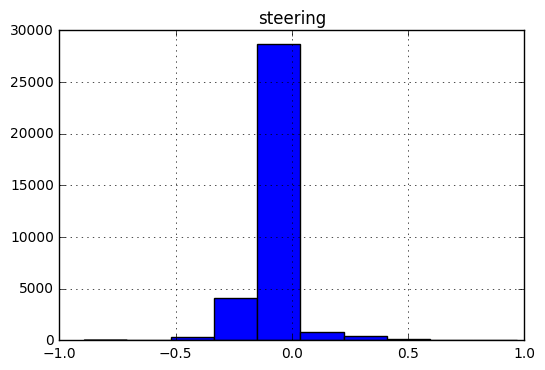

In [4]:
df.hist(column="steering")

#### What does the data distribution look like ignoring zero steering angles?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec29944278>]], dtype=object)

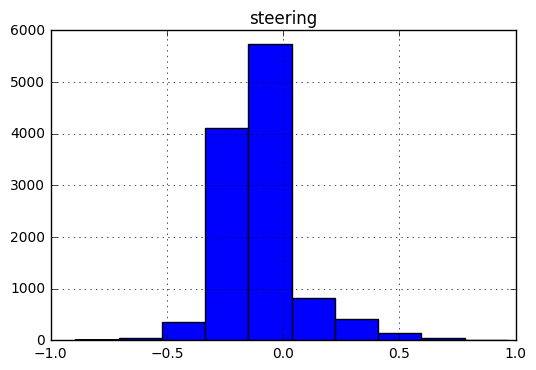

In [5]:
df_no_zeros = df[df.steering != 0]
df_no_zeros.hist(column="steering")

In [6]:
# Show a sample of the dataset
df.head(5)

,center,left,right,steering,speed
0,session_data/IMG/center_2017_01_21_00_16_39_18...,session_data/IMG/left_2017_01_21_00_16_39_183...,session_data/IMG/right_2017_01_21_00_16_39_18...,0.0,0.000078
1,session_data/IMG/center_2017_01_21_00_16_39_28...,session_data/IMG/left_2017_01_21_00_16_39_284...,session_data/IMG/right_2017_01_21_00_16_39_28...,0.0,0.000078
2,session_data/IMG/center_2017_01_21_00_16_39_38...,session_data/IMG/left_2017_01_21_00_16_39_386...,session_data/IMG/right_2017_01_21_00_16_39_38...,0.0,0.000082
3,session_data/IMG/center_2017_01_21_00_16_39_48...,session_data/IMG/left_2017_01_21_00_16_39_486...,session_data/IMG/right_2017_01_21_00_16_39_48...,0.0,0.000078
4,session_data/IMG/center_2017_01_21_00_16_39_58...,session_data/IMG/left_2017_01_21_00_16_39_587...,session_data/IMG/right_2017_01_21_00_16_39_58...,0.0,0.000078


## Print a random image from each camera

Shape:  (34703, 5)
Length:  34703
Random row:  18668
Image shape <PIL.Image.Image image mode=RGB size=320x160 at 0x7FEC298C04E0>


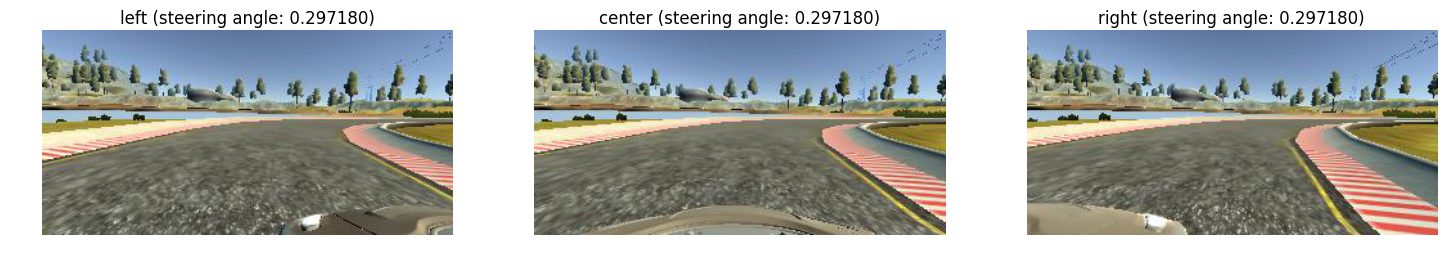

In [7]:
plt.rcParams["figure.figsize"] = (18, 10)

print("Shape: ", df.shape)
print("Length: ", len(df.index))

row = np.random.randint(len(df.index))
print("Random row: ", row)
print("Image shape {}".format(load_img(df.iloc[1]["center"].strip())))

i = 0
for camera in ["left", "center", "right"]:
    image = load_img(df.iloc[row][camera].strip())  #some columns have whitespace so strip it out
    image = img_to_array(image).astype("uint8")
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = "{} (steering angle: {:.6f})".format(camera, df.iloc[row]["steering"])
    plt.title(title)
    i += 1

## Pre-processing the data
A can be seen when you look at some of the data above, most of the samples are with the car driving straight - i.e. close to zero steering angle.

Lets start by building a new data file but ignoring all the low speed entrie which are mainly driving straight:

In [8]:
def read_log_file(random_drop_straight=False):
    """
    Read and process the log file that has already been opened above (in this notebook).
    Return X, y dataset.
    """
    #from IPython.core.debugger import Tracer
    #Tracer()() #this one triggers the debugger
    
    steering_offset = 0.25
    X, y = [], []
    
    for center_img, left_img, right_img, steering_angle, speed in df.values:
        
        if random_drop_straight:
            if abs(float(steering_angle)) == 0.:
                if random.random() < 0.5:
                    continue
        
        # Randomly choose from either the left, center or right camera - this ensures an even
        # distribution of the data - this histogram above shows that otherwise we have way 
        # more straigth driving than turns...
        cam_view = np.random.choice(["center", "left", "right"])
        if cam_view == "left":
            X += [left_img.strip()]
            y += [float(steering_angle) + steering_offset]
        
        elif cam_view == "center":
            X += [center_img.strip()]
            y += [float(steering_angle)]
        
        elif cam_view == "right":
            X += [right_img.strip()]
            y += [float(steering_angle) - steering_offset]
    
    return X, y

In [9]:
def random_darken(image):
    """Given an image (from Image.open -> not a numpy array), randomly darken a part of it."""
    w, h = image.size

    # Make a random box.
    x1, y1 = random.randint(0, w), random.randint(0, h)
    x2, y2 = random.randint(x1, w), random.randint(y1, h)

    # Loop through every pixel of our box (*GASP*) and darken.
    for i in range(x1, x2):
        for j in range(y1, y2):
            new_value = tuple([int(x * 0.5) for x in image.getpixel((i, j))])
            image.putpixel((i, j), new_value)
    return image

In [10]:
def augment_brightness(image):
    """
    apply random brightness on the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:, :, 2] = image[:, :, 2] * random_bright
    
    #image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB) *** LEAVE AS HSV ***
    
    return image

In [11]:
def random_translation(image, steer, trans_range, trans_y=False):
    """
    Translate image and compensate for the translation on the steering angle
    """
    
    rows, cols, channels = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * .4
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40 * np.random.uniform() - 40 / 2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (cols, rows))
    
    return image_tr, steer_ang

In [12]:
# NOTE: Changes to the CROP size must be reflected in drive.py !!!
def crop_and_resize(image, y1, y2, x1, x2, shape=(100, 100, 3)):
    """
    Crop and Resize images to given shape.
    """
    #height, width, channels = shape
    #image_resized = np.empty([height, width, channels])
    
    cropped_image = image[y1:y2, x1:x2]
    image_resized = imresize(cropped_image, shape)

    return image_resized

In [13]:
def process_image(image_path, steering_angle, augment):
    image = load_img(image_path)
    
    #if augment and random.random() < 0.5:
    #    image = random_darken(image)  # before numpy'd
    
    image = img_to_array(image)
    
    if augment:
        #image = random_shift(image, 0, 0.2, 0, 1, 2)  # only vertical
        trans_range = 50
        image, steering_angle = random_translation(image, steering_angle, trans_range) # , trans_y=True
        
        if random.random() < 0.5:
            image = flip_axis(image, 1)
            steering_angle = -steering_angle
    
        image = augment_brightness(image)
        
    return image.astype(np.float32), steering_angle

In [14]:
def preprocess(image):
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    trans_range = 50
    
    image = crop_and_resize(image, 20, 140, 0+trans_range, im_x-trans_range, shape=(66, 200, 3))
    image = (image / 255. - .5).astype(np.float32) #normalize
    return image

In [15]:
def generator(X, y, batch_size):
    while 1:
        batch_X, batch_y = [], []
        
        for i in range(batch_size):
            sample_index = random.randint(0, len(X) - 1)
            steering_angle = y[sample_index]
            
            image, steering_angle = process_image(X[sample_index], steering_angle, augment=True)
            
            image = preprocess(image)
            
            batch_X.append(image)
            batch_y.append(steering_angle)
            
        yield np.array(batch_X), np.array(batch_y)

#### Lets run the generator function and print some images from the pipeline so we can see the augmentation

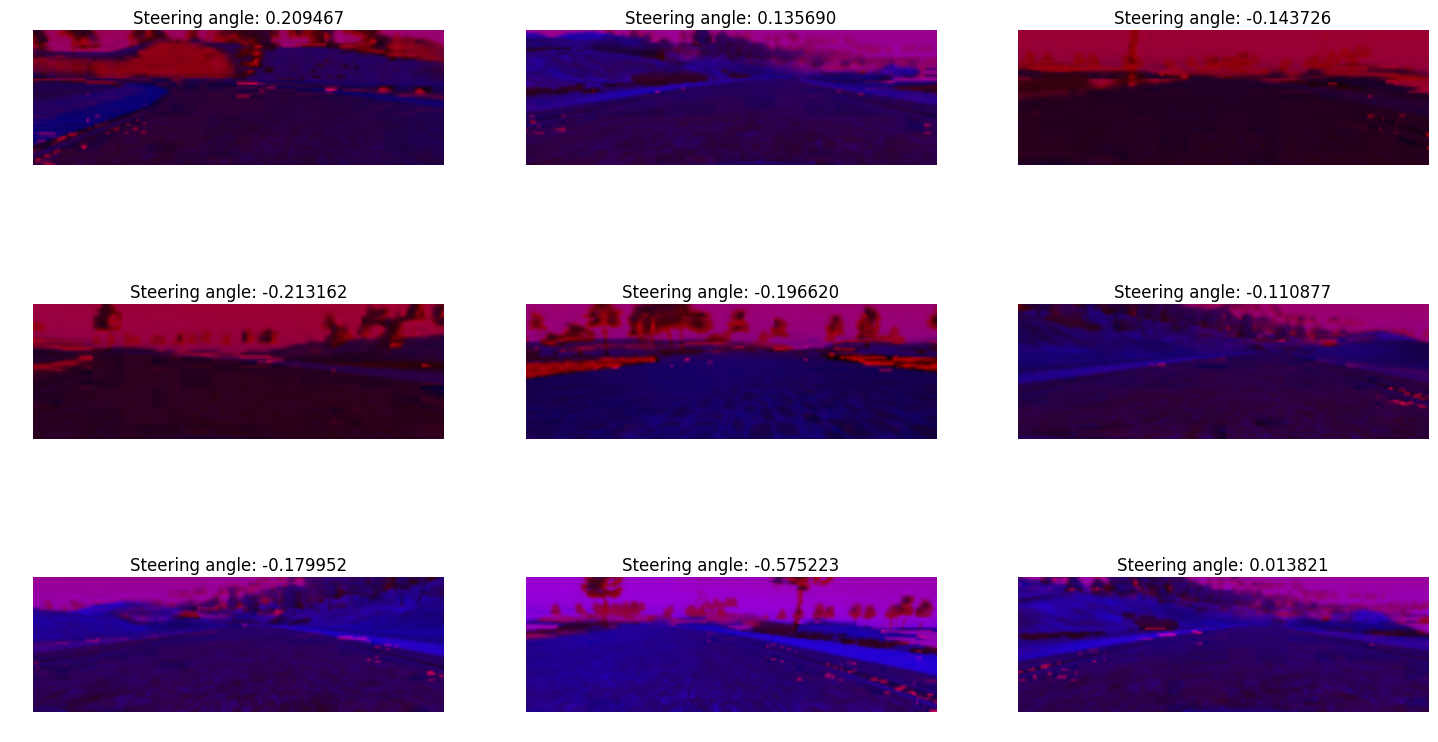

In [16]:
X, y = read_log_file(random_drop_straight=True)

plt.figure()
plt.rcParams["figure.figsize"] = (18, 10)

for pic in range(9):
    obj = generator(X, y, batch_size=1)
    next_batch = next(obj)
    
    image_from_array = next_batch[0][0]
    image_from_array = (image_from_array + .5) * 255 #undo the normalisation

    plt.subplot(3, 3, pic+1)
    plt.imshow(image_from_array.astype("uint8"))
    plt.axis('off')
    title = "Steering angle: {:.6f}".format(next_batch[1][0])
    plt.title(title)

## Build the ConvNet model

In [17]:
def model(load_model, shape):
    if load_model:
        print("Loading model and pre-trained weights from save/model.json and save/model.h5")
        
        with open("save/model.json", "r") as jfile:
            model = model_from_json(jfile.read())

        model.compile("adam", "mse")
        model.load_weights("save.model.h5")
    else:
        # This is the same as the Nvidia model
        model = Sequential([
            Conv2D(24, 5, 5, input_shape=shape, subsample=(2, 2), W_regularizer=l2(0.01), activation="elu"),
            Dropout(0.2),
            
            Conv2D(36, 5, 5, subsample=(2, 2), activation="elu"),
            Dropout(0.2),
            
            Conv2D(48, 5, 5, subsample=(2, 2), activation="elu"),
            Dropout(0.2),
            
            Conv2D(64, 3, 3, subsample=(1, 1), activation="elu"),
            Dropout(0.2),
            
            Conv2D(64, 3, 3, subsample=(1, 1), activation="elu"),
            Dropout(0.2),
            
            Flatten(),
                
            Dense(100, activation="elu"),
            Dropout(0.2),
            
            Dense(50, activation="elu"),
            Dropout(0.2),
            
            Dense(10, activation="elu"),
            
            Dense(1, activation="linear")
        ])

        model.compile(optimizer=Adam(lr=0.0001), loss="mse")
        #model.summary()
    
    return model

## Train the model

len X_train: 20907
len y_train: 20907
len X_val: 2323
len y_val: 2323
Epoch 1/30
40064/40064 [==============================] - 189s - loss: 0.0794 - val_loss: 0.0584
Epoch 2/30
40064/40064 [==============================] - 181s - loss: 0.0522 - val_loss: 0.0469
Epoch 3/30
40064/40064 [==============================] - 181s - loss: 0.0440 - val_loss: 0.0431
Epoch 4/30
40064/40064 [==============================] - 181s - loss: 0.0392 - val_loss: 0.0415
Epoch 5/30
40064/40064 [==============================] - 179s - loss: 0.0365 - val_loss: 0.0380
Epoch 6/30
40064/40064 [==============================] - 180s - loss: 0.0348 - val_loss: 0.0360
Epoch 7/30
40064/40064 [==============================] - 180s - loss: 0.0328 - val_loss: 0.0343
Epoch 8/30
40064/40064 [==============================] - 179s - loss: 0.0325 - val_loss: 0.0322
Epoch 9/30
40064/40064 [==============================] - 180s - loss: 0.0314 - val_loss: 0.0324
Epoch 10/30
40064/40064 [==============================] 

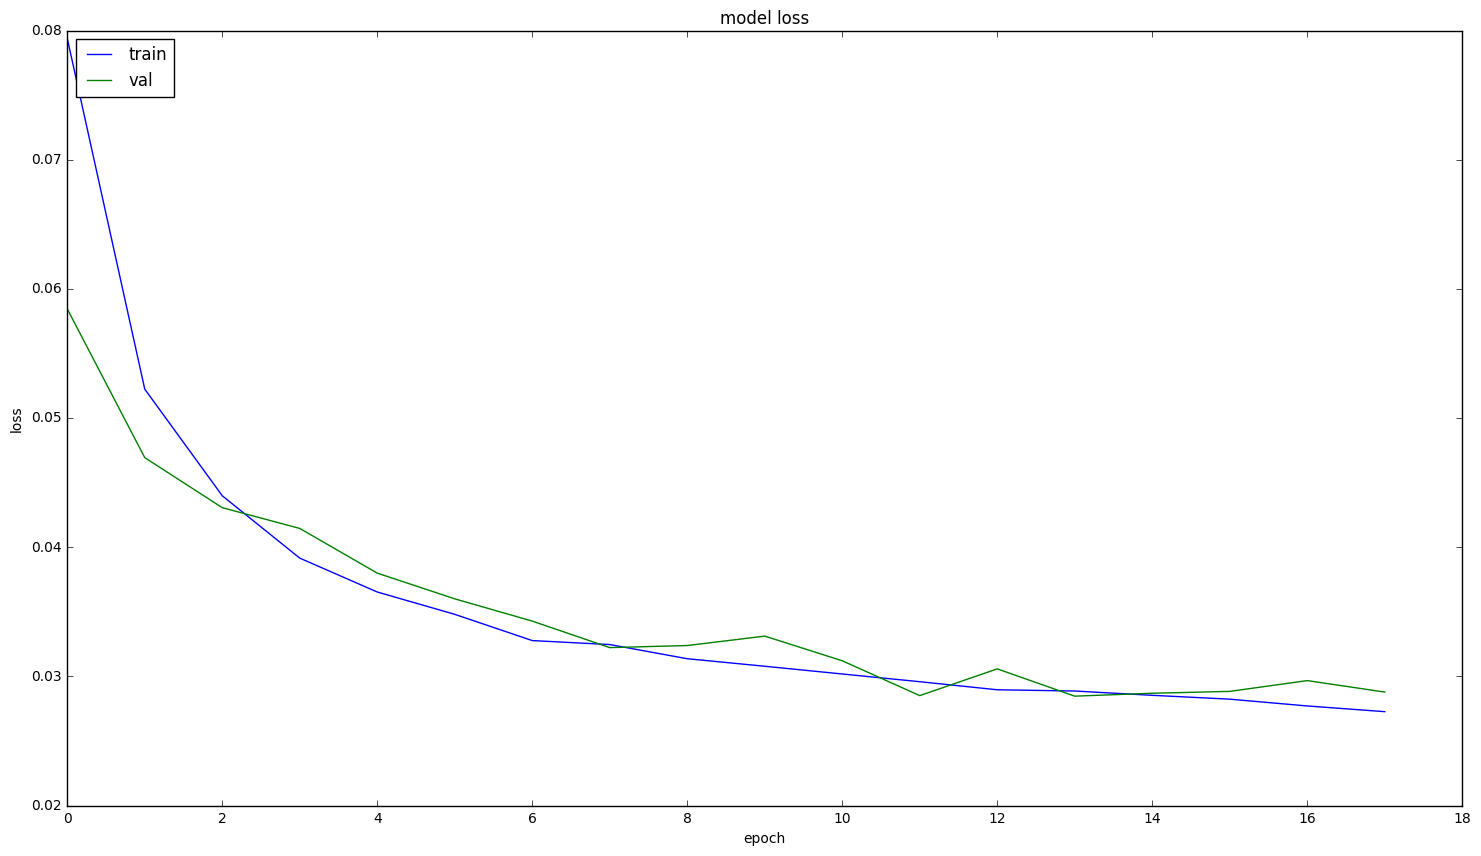



Training completed. Model saved to save/model.json and weights to save/model.h5


In [18]:
nb_epochs = 30
batch_size = 128


early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
save_weights = ModelCheckpoint("save/model.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)

net = model(load_model=False, shape=(66, 200, 3))

X, y = read_log_file(random_drop_straight=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

print("len X_train:", len(X_train))
print("len y_train:", len(y_train))
print("len X_val:", len(X_val))
print("len y_val:", len(y_val))


history = net.fit_generator(
    generator(X_train, y_train, batch_size),
    samples_per_epoch=128*313,
    nb_epoch=nb_epochs,
    callbacks=[early_stopping, save_weights],
    validation_data=generator(X_val, y_val, batch_size),
    nb_val_samples=len(X_val))

# Summarise history for loss
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

##
# Save model - note that the best weights are already saved above with the save_weights callback
##

json = net.to_json()
#model.save_weights("save/model.h5")
with open("save/model.json", "w") as f:
    f.write(json)

print("\n\nTraining completed. Model saved to save/model.json and weights to save/model.h5")

In [ ]:
# Current run:
# Changed to the Nvidia model. Added random horizontal translation.
#
#
# To-Do's
# 2. Try adding dropout after the conv layers
# 3. Test with BatchNorm (probably remove the dropout layers after the conv layers with this)
# 5. Apply ZCA Whitening from Keras library -- or -- Histogram equalization:
#      -- # Apply localized histogram localization
#         for i in range(X.shape[0]):
#             X[i] = exposure.equalize_adapthist(X[i])
# 6. Switch to SGD with momentum, etc. e.g. SGD(lr=0.01, decay=1e-6, momentum=0.1, nesterov=True)
# 8. Different learning rates?!?
# Try with HSV or YUV colur spaces (the blog used HSV and Nvidia used YUV)